In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from scipy.sparse.linalg import svds

In [3]:
movie = pd.read_csv("dataset/movies.csv")
rating = pd.read_csv("dataset/ratings.csv")


In [4]:
movie['year'] = movie['title'].str.extract(r'[(](?P<first>\d{4})')

In [5]:
rating

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [6]:
movie

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017
9739,193585,Flint (2017),Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018


In [7]:
movie['year'].fillna(0, inplace=True)
movie['year'] = movie['year'].astype(int)

In [8]:
movie[movie['movieId']==7767]


,movieId,title,genres,year
5013,7767,"Best of Youth, The (La meglio gioventù) (2003)",Drama,2003


In [9]:
rating[rating["movieId"]==7767]

,userId,movieId,rating,timestamp
71849,462,7767,4.5,1130433382
98261,606,7767,5.0,1175637600


In [10]:
movie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
 3   year     9742 non-null   int32 
dtypes: int32(1), int64(1), object(2)
memory usage: 266.5+ KB


In [11]:
tags = movie[['movieId','genres']].copy()

In [12]:
tags['split_genre'] = tags["genres"].str.split("|")
tags = tags.explode('split_genre')

In [13]:
movie

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995
...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,2017
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,2017
9739,193585,Flint (2017),Drama,2017
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,2018


In [14]:
def check_count_movie(df:pd.DataFrame)->None:
    df = df["year"].copy()
    df = df[df>0] #Убираем из выборки фильмы без даты
    groupby = df.groupby(by=df).count()
    groupby.plot(ylabel='Кол-во фильмов в год',legend=True)

In [15]:
def high_score_movie(rating:pd.DataFrame,type_agg:str="mean"):
    return rating.groupby(by='movieId').agg({"rating":[type_agg,"count"]})

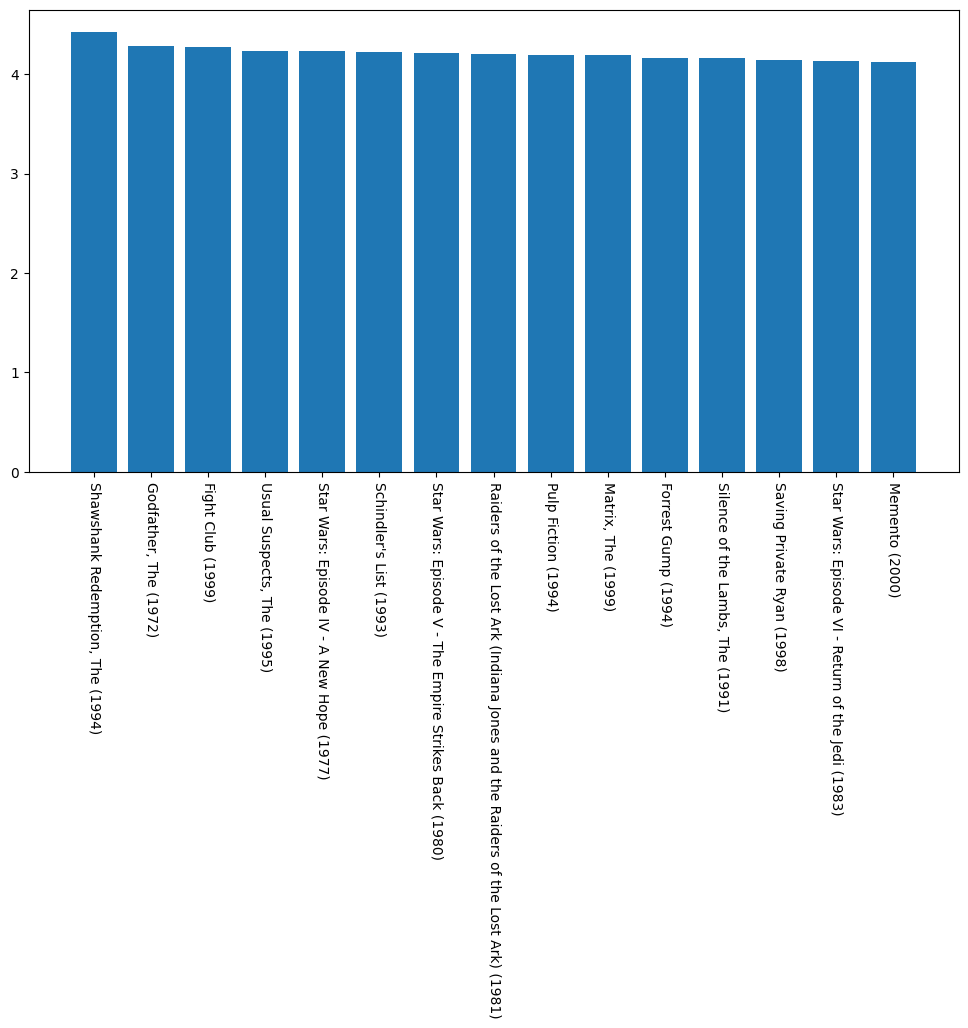

In [19]:
type_agg = "mean"
high_n = high_score_movie(rating=rating,type_agg=type_agg)['rating']
high_n = high_n[high_n["count"] > 150]
high_n = high_n.nlargest(15,'mean')
high_score_with_name = pd.merge(high_n, movie, on='movieId')
plt.figure(figsize=(12,6))
plt.bar(high_score_with_name["title"], high_score_with_name[type_agg])
plt.xticks(rotation=-90)
plt.show()
# print(high_score_movie(rating=rating,type_agg='median')['rating'].nlargest(10,"median"))

In [20]:
high_score_with_name['genres']

0                     Crime|Drama
1                     Crime|Drama
2     Action|Crime|Drama|Thriller
3          Crime|Mystery|Thriller
4         Action|Adventure|Sci-Fi
5                       Drama|War
6         Action|Adventure|Sci-Fi
7                Action|Adventure
8     Comedy|Crime|Drama|Thriller
9          Action|Sci-Fi|Thriller
10       Comedy|Drama|Romance|War
11          Crime|Horror|Thriller
12               Action|Drama|War
13        Action|Adventure|Sci-Fi
14               Mystery|Thriller
Name: genres, dtype: object

In [21]:
movie['year'].fillna(0, inplace=True)
movie['year'] = movie['year'].astype(int)

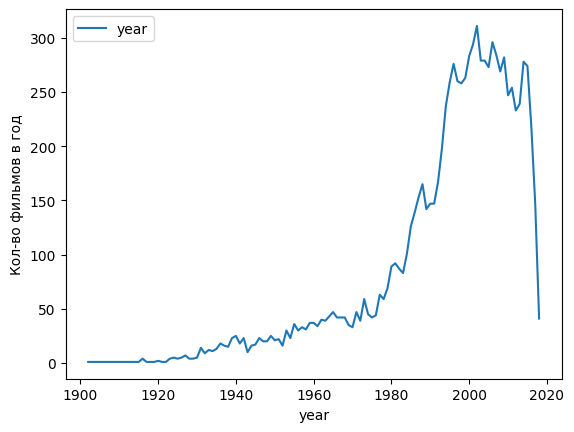

In [22]:
check_count_movie(movie)

# Рекомендательная система на основе жанров

In [23]:
tags['split_genre'] = tags['split_genre'].str.replace("-","").str.lower()

In [16]:
tfid_vec = TfidfVectorizer(stop_words='english')
tfid_genre = tfid_vec.fit_transform(tags['split_genre'])

In [17]:
cousin_sim = cosine_similarity(tfid_genre)

In [20]:
tags['one'] = [1]*tags.shape[0]


In [21]:
pivot_data = tags.pivot(index='movieId',values='one',columns='split_genre')

In [24]:
pivot_data.fillna(0,inplace=True)

In [25]:
cousin_sim = cosine_similarity(pivot_data)

In [86]:
tags['one'] = [1]* tags.shape[0]

In [87]:
pivot_data.fillna(0,inplace=True)

In [26]:
test_data_input = pd.DataFrame(columns=pivot_data.columns)
input_genre = ['action','scifi','adventure']

prepare_date = [1  if i in input_genre else 0 for i in pivot_data.columns]

test_data_input.loc[0] = prepare_date

In [45]:
test_val.shape

(20,)

In [35]:
# print(rating['movieId'])
tags_complited = pd.merge(rating, tags, on='movieId')
tags_complited

,userId,movieId,rating,timestamp,genres,split_genre
0,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy,Adventure
1,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy,Animation
2,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy,Children
3,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy,Comedy
4,1,1,4.0,964982703,Adventure|Animation|Children|Comedy|Fantasy,Fantasy
...,...,...,...,...,...,...
160468,599,9008,2.0,1519371214,Horror|Sci-Fi,Sci-Fi
160469,599,9010,2.0,1498510976,Drama|Romance,Drama
160470,599,9010,2.0,1498510976,Drama|Romance,Romance
160471,599,9018,2.5,1498518830,Documentary|War,Documentary


In [37]:
tags_complited.groupby(by='movieId').agg({"split_genre":"count"})

,split_genre
movieId,
1,1075
2,156
3,204
4,609
5,204
...,...
9004,3
9005,3
9008,2


## Рекомендательная система через косинусного сходства

In [60]:
test_val = test_data_input.values.reshape(1,-1)

In [61]:
corr_values = np.array([cosine_similarity(pivot_data.values[i].reshape(1,-1),test_val)[0,0] for i in range(len(pivot_data.values))]) # Предпочитаемый выброр

In [64]:
indices = np.argpartition(corr_values, -50)[-50:]

In [65]:
movie.loc[indices]

,movieId,title,genres,year
2889,3864,Godzilla 2000 (Gojira ni-sen mireniamu) (1999),Action|Adventure|Sci-Fi,1999
3599,4941,Flash Gordon (1980),Action|Adventure|Sci-Fi,1980
2836,3793,X-Men (2000),Action|Adventure|Sci-Fi,2000
275,316,Stargate (1994),Action|Adventure|Sci-Fi,1994
8489,113345,Jupiter Ascending (2015),Action|Adventure|Sci-Fi,2015
1557,2094,"Rocketeer, The (1991)",Action|Adventure|Sci-Fi,1991
5896,33493,Star Wars: Episode III - Revenge of the Sith (...,Action|Adventure|Sci-Fi,2005
4422,6534,Hulk (2003),Action|Adventure|Sci-Fi,2003
9073,142509,Hardcore Henry (2015),Action|Adventure|Sci-Fi,2015
4306,6294,Bulletproof Monk (2003),Action|Adventure|Sci-Fi,2003


## Рекомендательная система через корреляционный анализ

In [41]:
test_val = test_data_input.values.reshape(-1)

In [57]:
corr_values = np.array([np.corrcoef(pivot_data.values[i], test_val)[0, 1] for i in range(len(pivot_data.values))]) # Предпочитаемый выброр

In [58]:
indices = np.argpartition(corr_values, -20)[-20:] # Предпочитаемый выбор для корреляции

In [59]:
movie.loc[indices]

,movieId,title,genres,year
6825,61210,Mutant Chronicles (2008),Action|Adventure|Sci-Fi,2008
911,1210,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi,1983
2889,3864,Godzilla 2000 (Gojira ni-sen mireniamu) (1999),Action|Adventure|Sci-Fi,1999
1058,1375,Star Trek III: The Search for Spock (1984),Action|Adventure|Sci-Fi,1984
8916,135567,Independence Day: Resurgence (2016),Action|Adventure|Sci-Fi,2016
8686,122892,Avengers: Age of Ultron (2015),Action|Adventure|Sci-Fi,2015
8688,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017
898,1196,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi,1980
6863,62383,"20,000 Leagues Under the Sea (1916)",Action|Adventure|Sci-Fi,1916
275,316,Stargate (1994),Action|Adventure|Sci-Fi,1994


# Рекомендательная система на основе оценок

In [16]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

In [17]:
rating_pivot = rating.pivot(index='movieId',columns='userId',values='rating')
rating_pivot.fillna(0,inplace=True)

In [18]:
rating_pivot

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
def recomm_system_beg(pivot:pd.DataFrame,rating:pd.DataFrame,movie:pd.DataFrame,userid:int):
    print(pivot.columns)
    neighbour_ids = []
    rating_high_movie = rating[rating['userId']==userid]
    rating_high_movie = rating_high_movie[rating_high_movie['rating']==rating_high_movie['rating'].max()]['movieId']
    print(rating_high_movie)
    random_film = np.random.randint(0,len(rating_high_movie))
    rand_film_id = rating_high_movie.iloc[random_film]
    print(rand_film_id)
    # print(rating_high_movie)
    rating_pivot_value = pivot[pivot.index==rand_film_id]
    # count_val_movie_score = rating[rating['userId']==userid].count()
    k = 8
    kNN = NearestNeighbors(n_neighbors=8, algorithm="brute", metric='cosine')
    kNN.fit(pivot)
    print(pivot.values.shape)
    movie_vec = rating_pivot_value
    print(movie_vec.shape)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(n)
        print(n)
    movie_name_film = movie[movie['movieId'].isin(neighbour_ids)][['title','genres']]
    print(movie_name_film)
    print(movie[movie['movieId']==rand_film_id][['title',"genres"]])
        # neighbour_ids.append(movie_inv_mapper[n])
    # neighbour_ids.pop(0)
    # print(rating_pivot_value)
    # print(count_val_movie_score)
    # print(rating_pivot_value.values.shape)

In [91]:
# rating_pivot = pd.pivot_table(data=rating,index='userId',columns='userId',values='rating')
# matrix = pd.pivot_table(data=rating, index='userId', columns='userId', values='rating', aggfunc='mean', fill_value=0)
rating_df = rating.set_index('userId')
rating_pivot = rating_df.pivot_table(index='userId', columns='userId', values='rating', aggfunc='sum')
rating_pivot.fillna(0, inplace=True)
# users = rating['userId'].unique()
# matrix = np.dot(users[:, None], users[None, :])

# print(rating_pivot)
# rating_pivot.fillna(0,inplace=True)
rating_high_movie = rating_pivot[rating_pivot.index==567]
print(rating_high_movie)
k = 4
neighbour_ids = []
kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric='cosine')
kNN.fit(rating_pivot)
movie_vec = rating_high_movie
neighbour = kNN.kneighbors(movie_vec, return_distance=False)
for i in range(0,k):
    n = neighbour.item(i)
    neighbour_ids.append(n)
    print(n)
rating_df_movie = rating[rating['userId'].isin(neighbour_ids)]['movieId']

userId  1    2    3    4    5    6    7    8    9    10   ...  601  602  603  \
userId                                                    ...                  
567     0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   

userId  604  605  606  607  608  609  610  
userId                                     
567     0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 610 columns]
566
405
407
406


In [115]:
data = pd.merge(movie, rating, on='movieId')
# print(data)
# Препроцессинг данных
# data['rating'] = data['rating'] / 5  # нормализовать оценки

# Выбрать алгоритм Collaborative Filtering
n_neighbors = 4
knn = NearestNeighbors(n_neighbors=n_neighbors, algorithm='brute', metric='cosine')
knn.fit(data[['userId', 'rating']])


# print(data[data['userId'] == 2][['movieId', 'rating']])

# Получить рекомендации для пользователя с id 1
user_id = 2
movie_ids = knn.kneighbors(data[data['userId'] == user_id][['userId', 'rating']], return_distance=False)
print(movie_ids[0])
# print(data[data['movieId'].isin(movie_ids[0])])
# Вывести рекомендации
print('Рекомендации для пользователя с id {}:'.format(user_id))
for movie_id in movie_ids[0]:
    try:
        print('Фильм {}: {}'.format(movie_id, data[data['movieId'] == movie_id]['title'].iloc[0]))
    except:
        pass

[90118 96728 91046  8652]
Рекомендации для пользователя с id 2:
Фильм 96728: Master, The (2012)


In [81]:
rating_df_movie

0            1
1            3
2            6
3           47
4           50
         ...  
61548     5620
61549    33669
61550    44840
61551    46972
61552    56949
Name: movieId, Length: 406, dtype: int64

In [74]:
recomm_system_beg(pivot=rating_pivot,rating=rating,movie=movie,userid=500)

Int64Index([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,
            ...
            601, 602, 603, 604, 605, 606, 607, 608, 609, 610],
           dtype='int64', name='userId', length=610)
79912     176
79938    1175
79943    1282
79948    1747
79950    1784
79966    2355
79968    2542
79973    2700
79975    2858
79978    2997
79981    3114
79985    3355
79991    4306
Name: movieId, dtype: int64
2542
(610, 610)
(0, 610)


ValueError: Found array with 0 sample(s) (shape=(0, 610)) while a minimum of 1 is required by NearestNeighbors.

# Возможные варианты для дальнейшего исследования

In [ ]:
corr_matrix = np.corrcoef(test_data_input.values ,pivot_data.values) # Корреляционный анализ жанров

max_corr = np.max(corr_matrix) # выбор максимального значений в корреляции

max_corr_idx = np.unravel_index(np.argmax(corr_matrix), corr_matrix.shape) # Выбор индекса коррелируемого значение

In [292]:
corr_values_kendal = np.array([stats.pearsonr(pivot_data.values[i], test_val)[0] for i in range(len(pivot_data.values))])

# Просмотр алгоритмов корреляции, Пирсона, Спирмана и Кендалла

In [ ]:
top_3 = corr_matrix[np.argsort(corr_matrix)[-3:]] # Выбор вариантов из корреляции

In [ ]:
max_corr_idx = np.argmax(corr_values) 
max_corr_value = pivot_data.values[max_corr_idx] # Выбор вариантов из корреляции

In [ ]:
top_3 = np.partition(corr_values, -3)[-3:] # Выбор вариантов из корреляции

In [ ]:
indices = np.flip(np.argsort(corr_values))[:3]  # Выбор вариантов из корреляции

In [ ]:
top_3_arg = np.argsort(corr_matrix)[-3:] # Выбор вариантов из корреляции

In [ ]:
indices = np.unravel_index(np.argpartition(corr_matrix, -3, axis=None)[-3:], corr_matrix.shape) # Выбор вариантов из корреляции

In [ ]:
corr_matrix = pivot_data.corrwith(test_data_input) # Корреляция через пандас

In [ ]:
most_similar_values = corr_matrix.nlargest(5) # Вывод 5 значений из пандаса